# Title
blabla

### Install necessary packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import math
import seaborn as sns

### Load data 

In [2]:
df = pd.read_csv("listings_antwerpen.csv")

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,50904,aplace/antwerp: cosy suite - fashion district,234077,Karin,NaN,Historisch Centrum,51.21825,4.39901,Hotel room,109,1,1,5/6/2015,0.01,4,263
1,116134,Trendy Vacation Apartment Antwerp,586942,Paul,NaN,Eilandje,51.23051,4.40593,Entire home/apt,150,2,101,9/5/2020,0.96,1,358
2,224333,Large stylish room in 1930s house + garden,1167377,Geert,NaN,Deurne Zuid West,51.19772,4.45853,Private room,16,14,2,7/4/2020,0.02,2,359
3,224682,APARTMENT ROSCAM - OLD CENTRE ANTWERP,1263933,Kristien,NaN,Sint-Andries,51.21722,4.39790,Entire home/apt,115,2,336,3/8/2020,3.18,1,147
4,345959,Marleen's home in Antwerp city,1754396,Marleen,NaN,Markgrave,51.19935,4.40154,Entire home/apt,55,2,55,9/22/2020,0.53,2,338


### Data processing

Lets check for nulls in the column values first

In [4]:
df.isnull().sum()

id                                   0
name                                 0
host_id                              0
host_name                            1
neighbourhood_group               1703
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                        309
reviews_per_month                  309
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [5]:
df = df.drop(columns=['neighbourhood_group'])

For now all data can be keept, as the specification of interest (room_type, price, neighbourhood, availability_365 and minimum nights) are all complete.

Get an overview of the values contained in the attributes of interest and check whether the prices, minimum nights and availability per year have reasonable values for each attribute. 

In [6]:
[df['room_type'].unique(), df[['price', 'minimum_nights','availability_365']].describe(), df['neighbourhood'].unique()]

[array(['Hotel room', 'Entire home/apt', 'Private room', 'Shared room'],
       dtype=object),              price  minimum_nights  availability_365
 count  1703.000000     1703.000000       1703.000000
 mean     90.819143        3.518497        224.576629
 std     120.394168       11.266695        127.269396
 min      12.000000        1.000000          0.000000
 25%      49.000000        1.000000         90.000000
 50%      70.000000        2.000000        242.000000
 75%     100.000000        2.000000        358.000000
 max    3200.000000      300.000000        365.000000, array(['Historisch Centrum', 'Eilandje', 'Deurne Zuid West',
        'Sint-Andries', 'Markgrave', 'Amandus - Atheneum',
        'Borgerhout Intra Muros Noord', 'Hoogte', 'Harmonie',
        'Borgerhout Intra Muros Zuid', 'Oud - Berchem', 'Stadspark',
        'Linkeroever', 'Centraal Station', 'Universiteitsbuurt', 'Zuid',
        'Zurenborg', 'Stuivenberg', 'Deurne Dorp - Gallifort',
        'Haringrode', 'Groenenho

### Is it reasonable to use minimum_nights, availability and number of reviews to predict the price of airbnb objetcs in Antwerpen in a linear model? 

To answer this question lets follow the below steps:
1. Preselect the features mentioned above.
2. Run the feature selection via pearson corralation test and analyse the correlation within the resulting heatmap. 
3. To run a linear regression later ensure that independece assumption is met. This is done by checking the correlation between the input variables. 

1. Lets focus on the numerical values first. 

In [7]:
df_1 = df[['price', 'minimum_nights','availability_365','number_of_reviews']]

2. The heatmap below shows the pearson-correlation between all of the attributes. A pearson-correlation of 1 indicates a perfect linear relationship, whereas 0 indicates no linear relationship at all.  

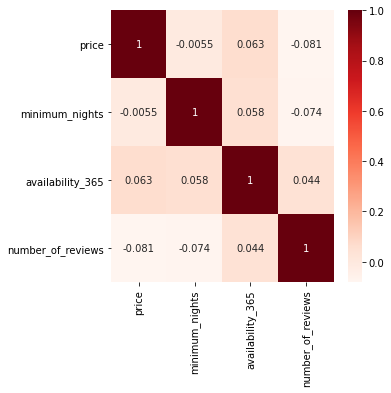

In [8]:
plt.figure(figsize=(5,5))
cor = df_1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

3. From the abvoe result we could ensure the independence assuption for a linear regression model. However, since there seems to be only very little (linear-) correaltion among the attributes a prediction with a linear incluse of those would most likely not be very precise.

The result is as expected and forces us to dig deeper. There are two ideas of how to create two more feature from the existing data, that most likely will have better predicting power. 

### What are reasonable geograpical groups of Airbnb objects in Antwerpen? 

The two possibilities we want to check here are the neighbourhood and the distance to the city center.
For this let us:
1. Use the neighbourhoods given, to group the data.
2. Group the neighbourhoods via k-means
3. Calculate the distance for each point to the city center of Antwerpen (51.2212236,4.3989646, being the coordinates of the antwerpen town hall.)

Then creat dummies for all the categories.

#### Firstly lets have a look at the neighbourhoods

In [9]:
df['neighbourhood'].value_counts()

Historisch Centrum              236
Theaterbuurt-Meir               150
Amandus - Atheneum              123
Centraal Station                103
Stadspark                       101
Zuid                             93
Sint-Andries                     75
Universiteitsbuurt               74
Borgerhout Intra Muros Zuid      67
Brederode                        62
Borgerhout Intra Muros Noord     57
Eilandje                         55
Stuivenberg                      53
Oud - Berchem                    53
Harmonie                         37
Haringrode                       33
Borgerhout Extra Muros           28
Zurenborg                        25
Groenenhoek                      22
Markgrave                        22
Deurne Zuid West                 21
Kiel                             21
Middelheim                       14
Hoogte                           14
Deurne Zuid Oost                 14
Linkeroever                      14
Hoboken - Centrum                14
Nieuw - Kwartier Oost       

There are to many groups of neighbourhoods and many of them contain only very little objects. Therefore the data is celaned to only contain the objects in neighbourhoods with more than 30 objects.

In [10]:
list_above_30 = (df['neighbourhood'].value_counts()[df['neighbourhood'].value_counts()>=30]).index
df_n = df[df['neighbourhood'].isin(list_above_30)].reset_index(drop=True)

#### Second we generate cluster ids for each object using the (here somehow generically) approach of k-means clustering

In [48]:
# Clustering the object du to their geographical position using 10 resultting clusters
# and fixing the random state to replicate the work later on.
X = df_n[['latitude','longitude']].to_numpy()
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

Let us have a look at the results in correspondence to the city center:

Text(40, -40, 'City Center')

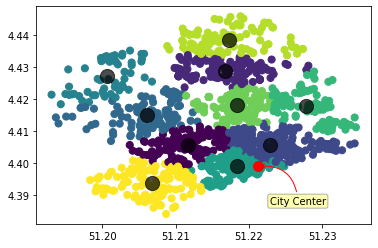

In [49]:
# .predict retruns the label 0-9 for each object, which corresponds to the cluster id.
y_kmeans = kmeans.predict(X)
plt.scatter(X[:,0],X[:,1], c=y_kmeans, s=50)

# .cluster_center returns the coordinates of each cluster center 0 to 9.
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.7)
plt.plot(51.2212236,4.3989646, 'ro', ms=10)
plt.annotate('City Center', xy=(51.2212236,4.3989646), xytext=(40,-40), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='red'))

In [13]:
# Add new column to the dataframe containing the cluster id for each object
df_n['cluster_id'] = y_kmeans

#### Next we calculate the distances to the town hall for each object using the haversine distance formula and assesing the distance to each object at last

In [14]:
distance_to_center = []
lat_center = math.radians(51.2212236)
lon_center = math.radians(4.3989646)
r = 6373.0
for i in range(0,len(df_n)):
    lon = math.radians(df_n['longitude'].iloc[i])
    lat = math.radians(df_n['latitude'].iloc[i])
    
    dlon = lon_center - lon
    dlat = lat_center - lat
    
    a = math.sin(dlat / 2)**2 + math.cos(lat_center) * math.cos(lat) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = r*c
    
    distance_to_center.append(distance)

In [15]:
df_n['distance_to_center'] = distance_to_center

# Let us have a look at the resulting distances to make sure the calculations have a reasonable output.
df_n['distance_to_center'].describe()

count    1372.000000
mean        1.440030
std         0.837054
min         0.024459
25%         0.706400
50%         1.411026
75%         2.027448
max         3.568530
Name: distance_to_center, dtype: float64

The calculated distances seem to be reasonable compating with the clusters above. 

Alternatively one could use the packages gedesic or greatcircle form geaopy.distance or even the package for the haversine distance above to directly calculate the distances. 

In [16]:
df_n.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,cluster_id,distance_to_center
0,50904,aplace/antwerp: cosy suite - fashion district,234077,Karin,Historisch Centrum,51.21825,4.39901,Hotel room,109,1,1,5/6/2015,0.01,4,263,5,0.330768
1,116134,Trendy Vacation Apartment Antwerp,586942,Paul,Eilandje,51.23051,4.40593,Entire home/apt,150,2,101,9/5/2020,0.96,1,358,2,1.141205
2,224682,APARTMENT ROSCAM - OLD CENTRE ANTWERP,1263933,Kristien,Sint-Andries,51.21722,4.39790,Entire home/apt,115,2,336,3/8/2020,3.18,1,147,5,0.451454
3,363155,1-bedroom apartment with court yard,1835458,Roos,Amandus - Atheneum,51.22119,4.41951,Entire home/apt,47,2,19,10/20/2020,0.19,1,354,7,1.431299
4,366252,ROOM IN FAMILY HOME near C. Station,1820186,Fronk & Lieve,Borgerhout Intra Muros Noord,51.21601,4.43432,Private room,35,1,104,9/15/2019,1.00,6,365,8,2.530514


Before we run the model to figure out the impact of the different clasiffications, let us have a look on the different room types as well

In [39]:
df_n['room_type'].value_counts()

Entire home/apt    1053
Private room        285
Shared room          19
Hotel room           15
Name: room_type, dtype: int64

Even though the number of shared room and hotel objects ist quite small, the catergories are non the less included as such, since they are expected to have a big impact on the resulting price. 

#### Let us use our knowledge from class to generate dummies for each category

In [35]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    X = df.drop(columns=['longitude','latitude','price','id','name','host_id','host_name','last_review','calculated_host_listings_count',])
    y = df['price']
    
    X_num = X.select_dtypes(exclude=['object','O']).fillna(X.mean())
    X_cat = X.select_dtypes(include=['object','O'])
    
    X = pd.concat([X_num, pd.get_dummies(X_cat, drop_first=True)], axis=1)                    
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df_n)  

#### Run a linear model with 30 % test split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Four steps from class

#Instantiate
lm_model = LinearRegression(normalize=True) 

lm_model.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

#### Use the function from class to see the effect of each coefficient on the price

In [37]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
23,room_type_Shared room,-68.465900,68.465900
14,neighbourhood_Oud - Berchem,63.006147,63.006147
11,neighbourhood_Haringrode,46.362620,46.362620
22,room_type_Private room,-21.314609,21.314609
10,neighbourhood_Eilandje,18.121121,18.121121
18,neighbourhood_Theaterbuurt-Meir,-18.103478,18.103478
15,neighbourhood_Sint-Andries,-17.364249,17.364249
5,distance_to_center,-12.646287,12.646287
7,neighbourhood_Borgerhout Intra Muros Zuid,12.195874,12.195874
16,neighbourhood_Stadspark,-11.882099,11.882099


### Is it possible to predict prices of air bnb objects with the data and model at hand? 

In [45]:
y_test_preds = lm_model.predict(X_test)
'The r-squared score for the model using all the reasonable variables was {} on {} values.'.format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using all the reasonable variables was -0.0012343507082119842 on 412 values.'

The resulting prediction is very poor and therefore other models or/and variables should be used to help predictiong prices for air bnb objects.